# GPT for Tabular Classification with SHAP Analysis

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import shap


## Step 1: Data Loading

In [7]:
# Define column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop the 'difficulty_degree' column
train.drop("difficulty_degree", axis=1, inplace=True)
test.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Convert labels to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert each row into a string format for tokenization (GPT needs text inputs)
train_sequences = [" ".join(map(str, row)) for row in X_train]
test_sequences = [" ".join(map(str, row)) for row in X_test]


In [8]:
# Load GPT-2 tokenizer and manually set padding token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as padding token

# Tokenize dataset
train_encodings = tokenizer(train_sequences, truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(test_sequences, truncation=True, padding=True, max_length=128, return_tensors="tf")

# Convert labels to NumPy int32 arrays & reshape to 1D
y_train = np.array(y_train).astype(np.int32).reshape(-1)
y_test = np.array(y_test).astype(np.int32).reshape(-1)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(32)


In [9]:
# Load GPT-2 base model
from transformers import TFGPT2Model, AutoTokenizer
gpt2_model = TFGPT2Model.from_pretrained("gpt2")

# Define a custom model with a classification head
class GPT2IDSModel(tf.keras.Model):
    def __init__(self, gpt2_model):
        super(GPT2IDSModel, self).__init__()
        self.gpt2 = gpt2_model
        self.classifier = tf.keras.layers.Dense(2, activation="softmax")  # 2 classes (Normal, Attack)

    def call(self, inputs, training=False):
        gpt2_output = self.gpt2(inputs)[0]  # Extract GPT-2 embeddings
        pooled_output = tf.reduce_mean(gpt2_output, axis=1)  # Average pooling across tokens
        return self.classifier(pooled_output)

# Initialize the model
model = GPT2IDSModel(gpt2_model)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [10]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

# Train the model
print("Training GPT-2 Based IDS Model...")
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)


Training GPT-2 Based IDS Model...
Epoch 1/20


2025-03-24 17:51:08.900793: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tensorflow/python/platform/../../cuda
  /home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tensorflow/python/platform/../../../../../..
  /home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tensorflow/python/platform/../../../.

UnknownError: Graph execution error:

Detected at node gpt2ids_model/tfgpt2_model/transformer/h_._0/ln_1/batchnorm/Rsqrt defined at (most recent call last):
  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_624236/559965639.py", line 9, in <module>

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 1804, in fit

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 1398, in train_function

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 1381, in step_function

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 1370, in run_step

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 1147, in train_step

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/tmp/ipykernel_624236/956764800.py", line 13, in call

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/training.py", line 588, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 774, in run_call_with_unpacked_inputs

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/models/gpt2/modeling_tf_gpt2.py", line 802, in call

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 774, in run_call_with_unpacked_inputs

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/models/gpt2/modeling_tf_gpt2.py", line 509, in call

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/models/gpt2/modeling_tf_gpt2.py", line 513, in call

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/transformers/models/gpt2/modeling_tf_gpt2.py", line 276, in call

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/engine/base_layer.py", line 1142, in __call__

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/awakili/anaconda3/envs/DLEnv/lib/python3.9/site-packages/tf_keras/src/layers/normalization/layer_normalization.py", line 297, in call

JIT compilation failed.
	 [[{{node gpt2ids_model/tfgpt2_model/transformer/h_._0/ln_1/batchnorm/Rsqrt}}]] [Op:__inference_train_function_27079]

In [ ]:
# Evaluate on the test set
print("Evaluating GPT-2 Based IDS Model...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Evaluating GPT-2 Based IDS Model...
705/705 [==============================] - 829s 1s/step - loss: 0.7701 - accuracy: 0.8206
Test Loss: 0.770138144493103, Test Accuracy: 0.820573091506958


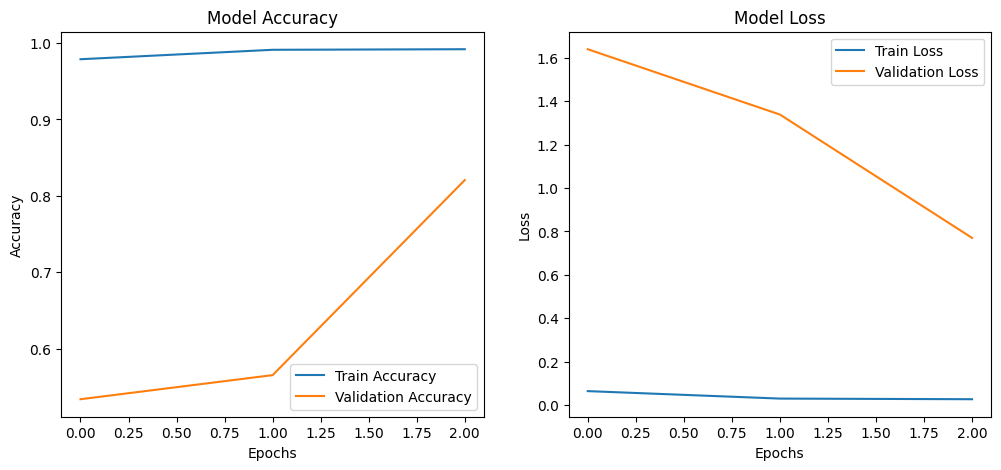

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


705/705 [==============================] - 917s 1s/step


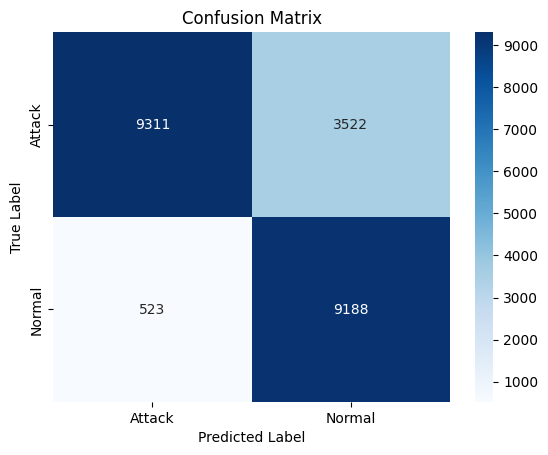

              precision    recall  f1-score   support

      Attack       0.95      0.73      0.82     12833
      Normal       0.72      0.95      0.82      9711

    accuracy                           0.82     22544
   macro avg       0.83      0.84      0.82     22544
weighted avg       0.85      0.82      0.82     22544



In [ ]:
# Generate predictions
# Generate predictions
y_pred_proba = model.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig("visualization/GPT2_Confusion-Matrix.png")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))


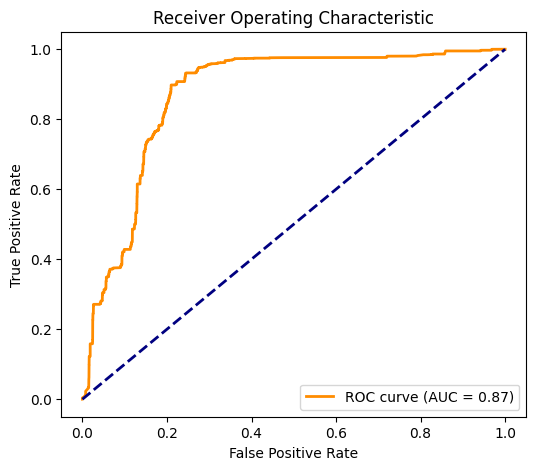

In [ ]:
# Compute ROC Curve
y_pred_proba = y_pred_proba[:, 1]  # Probability for class 'Normal'
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig("GPT2_ROC-Curve.png")
plt.show()


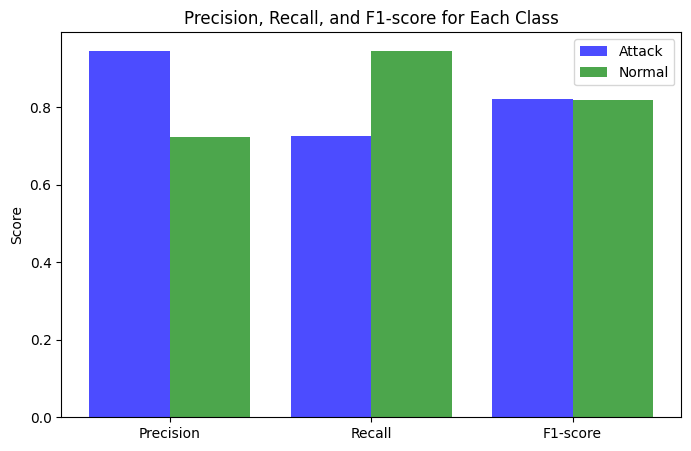

In [ ]:
# Extract metrics from classification report
report_dict = classification_report(y_test, y_pred, target_names=["Attack", "Normal"], output_dict=True)

precision_attack = report_dict["Attack"]["precision"]
recall_attack = report_dict["Attack"]["recall"]
f1_attack = report_dict["Attack"]["f1-score"]

precision_normal = report_dict["Normal"]["precision"]
recall_normal = report_dict["Normal"]["recall"]
f1_normal = report_dict["Normal"]["f1-score"]

# Metrics Labels and Values
metrics = ["Precision", "Recall", "F1-score"]
attack_values = [precision_attack, recall_attack, f1_attack]
normal_values = [precision_normal, recall_normal, f1_normal]

x = np.arange(len(metrics))

# Plot Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, attack_values, width=0.4, label="Attack", color="blue", alpha=0.7)
plt.bar(x + 0.2, normal_values, width=0.4, label="Normal", color="green", alpha=0.7)
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score for Each Class")
plt.legend()
plt.savefig("GPT2_Metrics.png")
plt.show()
